## Нейросеть для классификации таблеток

## Этап 1. Загрузка и предобработка данных

### Загружаем датасет 

In [40]:
from torchvision.datasets import ImageFolder

dataset_path = './dataset/ogyeiv2/train'
dataset = ImageFolder(dataset_path) 

### Разделим датасет на обучающую и валидационную части

salazopyrin_en_500_mg
kalium_r
sicor_10_mg
algopyrin_500_mg
strepfen_8_75_mg
sicor_10_mg
sicor_10_mg
cataflam_50_mg
jutavit_c_vitamin
neo_citran


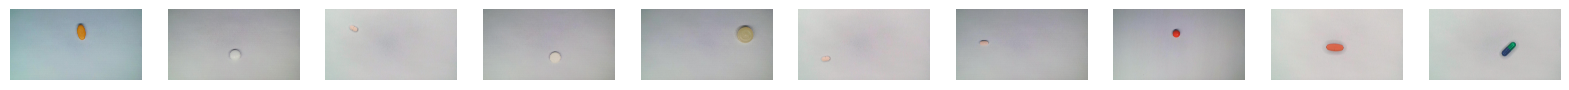

In [41]:
from torch.utils.data import random_split
from matplotlib import pyplot as plt


train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

# Визуализация датасета до трансформаций
fig = plt.figure(figsize=(20,5))
for index in range (1, 11):
    image, label = train_dataset[index]
    print(dataset.classes[label])
    plt.subplot(1, 10, index)
    plt.imshow(image)
    plt.axis('off')

### Создадим класс-обёртку, который позволяет корректно добавить трансформации к существующему датасету.

In [42]:
from torch.utils.data import Dataset


class TransformDataset(Dataset):
  def __init__(self, dataset, transforms):
    super(TransformDataset, self).__init__()
    self.dataset = dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    x, y = self.dataset[idx]
    return self.transforms(x), y
  

### Создаем трансформированные датасеты для обучения

In [43]:
from torchvision.transforms.v2 import RandomRotation, RandomPhotometricDistort, \
RandomHorizontalFlip, RandomVerticalFlip, Compose
from torchvision.transforms import ToTensor, Normalize, Resize


test_transforms = Compose([
    Resize((224, 224)), # подгоняем под размер входа модели
    ToTensor(),
    Normalize((0.5), (0.5))  # нормализация значений из [0, 1] в [-1, 1] путем вычитания 0.5 и делением на 0.5
]) 


train_transforms = Compose([
    # аугментация
    RandomHorizontalFlip(p=0.2),
    RandomVerticalFlip(p=0.2),
    RandomRotation([-90, 90], fill=184.), # фон изображений серый, поэтому заполнение серый

    Resize((224, 224)), 
    ToTensor(),
    Normalize((0.5), (0.5)),

]) 


train_dataset = TransformDataset(train_dataset, train_transforms)
val_dataset = TransformDataset(val_dataset, test_transforms)

print("Количество изображений в train:", len(train_dataset))
print("Количество изображений в val:", len(val_dataset))
print("Количество классов:", len(dataset.classes))
print("Список классов:", dataset.classes) 

Количество изображений в train: 1882
Количество изображений в val: 470
Количество классов: 84
Список классов: ['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg', 'algopyrin_500_mg', 'ambroxol_egis_30_mg', 'apranax_550_mg', 'aspirin_ultra_500_mg', 'atoris_20_mg', 'atorvastatin_teva_20_mg', 'betaloc_50_mg', 'bila_git', 'c_vitamin_teva_500_mg', 'calci_kid', 'cataflam_50_mg', 'cataflam_dolo_25_mg', 'cetirizin_10_mg', 'cold_fx', 'coldrex', 'concor_10_mg', 'concor_5_mg', 'condrosulf_800_mg', 'controloc_20_mg', 'covercard_plus_10_mg_2_5_mg_5_mg', 'coverex_4_mg', 'diclopram_75-mg_20-mg', 'dorithricin_mentol', 'dulsevia_60_mg', 'enterol_250_mg', 'favipiravir_meditop_200_mg', 'ibumax_400_mg', 'jutavit_c_vitamin', 'jutavit_cink', 'kalcium_magnezium_cink', 'kalium_r', 'koleszterin_kontroll', 'lactamed', 'lactiv_plus', 'laresin_10_mg', 'letrox_50_mikrogramm', 'lordestin_5_mg', 'merckformin_xr_1000_mg', 'meridian', 'metothyrin_10_mg', 'mez

### Упаковываем данные в удобный для обучения вид.

In [44]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
) 

## Этап 2. Объявление модели

In [ ]:
import torchvision
import torch
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

device_val = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device=device_val)


weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)

# переносим на GPU если оно есть
model.to(device)

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

### Заменим слой для классификации под число классов

In [ ]:
from torchsummary import summary
import torch.nn as nn


model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),  # Dropout как в оригинале
    nn.Linear(
        in_features=model.classifier[1].in_features, 
        out_features=84,
    )
)

# новый классификатор на то же устройство
model.classifier = model.classifier.to(device)

# Заморозка слоёв
for param in model.parameters():
    param.requires_grad = False

# Разморозка полносвязного слоя classifier
for param in model.classifier.parameters():
    param.requires_grad = True
    
# Проверка
summary(model, input_size=(3, 224, 224), device=device_val)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              SiLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              SiLU-6         [-1, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]             960
      BatchNorm2d-14         [-1, 24, 1

## Этап 3. Обучение или дообучение

### Объявляем функцию потерь и оптимизатор 

In [47]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Создаем функцию для обучения

In [ ]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for batch_index, data in enumerate(train_loader):
        # Извлечение батча
        inputs, labels = data
        # данные тоже должны быть на устройстве, где и модель
        inputs, labels = inputs.to(device), labels.to(device)
        # Обнуление градиентов
        optimizer.zero_grad()
        # Прямое распространение
        outputs = model(inputs)
        # Подсчёт ошибки
        loss = criterion(outputs, labels)
        # Обратное распространение
        loss.backward()
        # Обновление весов
        optimizer.step()

        # Суммирование ошибки за последние 20 батчей
        running_loss += loss.item()
        if batch_index % 20 == 19:
            last_loss = running_loss / 20. # средняя ошибка за 20 батчей
            print(f'Эпоха: {epoch_index}, батч: {batch_index}, ошибка {last_loss}')
            running_loss = 0.

    return last_loss

### Создадим сам процесс обучения

Во время каждой эпохи нужно:
1. Провести одну итерацию обучения.
2. Проверить ошибку модели на валидационном датасете.
3. Сохранить веса модели, если ошибка на валидации снизилась в сравнении с best_vloss (ошибкой прошлой эпохи).

In [ ]:
import torch

EPOCHS = 20

best_vloss = 1e5

for epoch in range(EPOCHS):
    print(f'Эпоха {epoch}')

    # Перевод модели в режим обучения
    model.train(True)
    # Эпоха обучения
    avg_loss = train_one_epoch(epoch)

    # Перевод модели в режим валидации
    model.eval()
    running_vloss = 0.0

    # Валидация
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)

    # Сохранение лучшей модели
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'./models/meds_classifier_{epoch}.pt'
        torch.save(model.state_dict(), model_path)

    print(f'В конце эпохи ошибка train {avg_loss}, ошибка val {avg_vloss}')

Эпоха 0
Эпоха: 0, батч: 19, ошибка 4.446590638160705
Эпоха: 0, батч: 39, ошибка 4.335680055618286
В конце эпохи ошибка train 4.335680055618286, ошибка val 4.033584117889404
Эпоха 1
Эпоха: 1, батч: 19, ошибка 3.9080772519111635
Эпоха: 1, батч: 39, ошибка 3.828213393688202
В конце эпохи ошибка train 3.828213393688202, ошибка val 3.654904365539551
Эпоха 2
Эпоха: 2, батч: 19, ошибка 3.5390264272689818
Эпоха: 2, батч: 39, ошибка 3.4850020527839662
В конце эпохи ошибка train 3.4850020527839662, ошибка val 3.370495557785034
Эпоха 3
Эпоха: 3, батч: 19, ошибка 3.2512919068336488
Эпоха: 3, батч: 39, ошибка 3.2283876538276672
В конце эпохи ошибка train 3.2283876538276672, ошибка val 3.130389928817749
Эпоха 4
Эпоха: 4, батч: 19, ошибка 3.0444621205329896
Эпоха: 4, батч: 39, ошибка 3.026883614063263
В конце эпохи ошибка train 3.026883614063263, ошибка val 2.9501304626464844
Эпоха 5
Эпоха: 5, батч: 19, ошибка 2.866530787944794
Эпоха: 5, батч: 39, ошибка 2.790200042724609
В конце эпохи ошибка train 2

## Этап 4. Оценка качества

### Загрузим ранее обученную нами модель из файла


In [59]:
model_path = './models/meds_classifier_14.pt'

model = efficientnet_b3()

model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),  # Dropout как в оригинале
    nn.Linear(
        in_features=model.classifier[1].in_features, 
        out_features=84,
    )
)

# Заморозка слоёв
for param in model.parameters():
    param.requires_grad = False

# Разморозка полносвязного слоя classifier
for param in model.classifier.parameters():
    param.requires_grad = True


model.load_state_dict(torch.load(
    model_path, 
    weights_only=True,  # понадобятся только веса
))

<All keys matched successfully>

### На валидационных данных запустим предсказания и соберем предсказанные и истинные данные 

In [60]:
labels_predicted = []
labels_true = []

model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels = data

        outputs = model(images)
        # argmax по всем примерам, так как torch.max возвращает два параметра
        # максимальные значения в выборке и позиции, на которых они находятся (argmax)
        _, predicted = torch.max(outputs, 1) # argmax по всем примерам
        labels_predicted.extend(predicted.numpy())
        labels_true.extend(labels.numpy()) 

### Подсчитаем итоговую оценку

In [61]:
from sklearn.metrics import classification_report

print(classification_report(labels_true, labels_predicted, target_names=dataset.classes))

                                  precision    recall  f1-score   support

                 acc_long_600_mg       0.88      1.00      0.93         7
               advil_ultra_forte       1.00      1.00      1.00         5
                   akineton_2_mg       0.75      1.00      0.86         3
      algoflex_forte_dolo_400_mg       1.00      0.83      0.91         6
           algoflex_rapid_400_mg       1.00      1.00      1.00         5
                algopyrin_500_mg       0.75      1.00      0.86         9
             ambroxol_egis_30_mg       1.00      0.80      0.89         5
                  apranax_550_mg       1.00      1.00      1.00         7
            aspirin_ultra_500_mg       0.75      0.75      0.75         8
                    atoris_20_mg       0.88      0.78      0.82         9
         atorvastatin_teva_20_mg       1.00      0.50      0.67         4
                   betaloc_50_mg       1.00      1.00      1.00         4
                        bila_git     

/home/anton/PycharmProjects/tablets-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/PycharmProjects/tablets-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/PycharmProjects/tablets-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

## Вывод

**1. На каких 5 классах модель ошибается чаще всего?**

- nebivolol_sandoz_5_mg – F1 = 0.00 (precision=0.00, recall=0.00, support=3). Модель не распознала ни одного примера правильно.
- theospirex_150_mg – F1 = 0.25 (precision=0.25, recall=0.25, support=4).
- voltaren_dolo_rapid_25_mg – F1 = 0.33 (precision=1.00, recall=0.20, support=5). Точность идеальна, но полнота очень низкая (находит только 1 из 5, но без ложных срабатываний).
- narva_sr_1_5_mg_retard – F1 = 0.43 (precision=0.50, recall=0.38, support=8).
- covercard_plus_10_mg_2_5_mg_5_mg – F1 = 0.57 (precision=0.50, recall=0.67, support=3).

**2. Почему модель может ошибаться на этих классах?**

- Недостаток данных (Малое количество примеров);
- Визуальное сходство с другими классами.


**3. На каких классах модель не совершает ошибок?**

- advil_ultra_forte
- algoflex_rapid_400_mg
- apranax_550_mg
- betaloc_50_mg
- c_vitamin_teva_500_mg
- cataflam_50_mg
- condrosulf_800_mg
- diclopram_75-mg_20-mg
- merckformin_xr_1000_mg
- neo_citran
- quamatel_40_mg
- sinupret_forte
- verospiron_25_mg
- vita_c

**4. Почему эти классы модель распознаёт безошибочно?**

- Уникальные и стабильные визуальные признаки (цвет, форма), которые редко встречается у других классов в датасете.
- Достаточное количество примеров.

**5. Как можно улучшить точность классификатора?**

* Сбор большего количества данных для слабых классов.
* Активно использовать аугментации, имитирующие реальные условия.
* Постепенная разморозка слоёв. Можно разморозить и дообучить последние несколько сверточных блоков EfficientNet, чтобы модель лучше адаптировалась к конкретной задаче.